### Dictionary

train_direction = 0 south, 1 north
train_type = 0 Local, 1 Limited, 2 Bullet
train_

In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import re
import random
import operator
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.cross_validation import KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif

from func import *

# inline plot
%matplotlib inline
#%%javascript
#IPython.OutputArea.auto_scroll_threshold = 9999;

/Users/albarron/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
#%load 'data/raw-twt2016-01-26-14/21/09.csv'
df = pd.read_csv("data/raw-twt2016-01-26-14-21-09.csv",sep='\t',error_bad_lines=False)
# df.head(5)
print len(df.index)
list(df.columns.values)

3199


['Unnamed: 0',
 'created_at',
 'favorite_count',
 'favorited',
 'hashtags',
 'id',
 'in_reply_to_screen_name',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'lang',
 'media',
 'place',
 'retweet_count',
 'retweeted',
 'retweeted_status',
 'source',
 'text',
 'truncated',
 'urls',
 'user',
 'user_mentions']

Cleanin' the data

In [3]:
# Fill in blank hashtags
df = df.where((pd.notnull(df)), np.nan)
df["hashtags"].fillna('')

# Add some date/time things
df["created_at"] = pd.to_datetime(df["created_at"], errors='coerce')

df["day_of_week"] = df["created_at"].apply(lambda x: x.weekday())
df["day_of_month"] = df["created_at"].apply(lambda x: x.day)
df["month"] = df["created_at"].apply(lambda x: x.month)
df["time_of_day"] = df["created_at"].apply(lambda x: get_time_of_day(x))

tod_Dummy = pd.get_dummies(df['time_of_day'])
print(tod_Dummy.head(5))
print tod_Dummy.count()
# del tod_Dummy['shutdown']

# df['in_reply_to_screen_name'].fillna(-1)
# df['in_reply_to_status_id'].fillna(-1)
# df['in_reply_to_user_id'].fillna(-1)
# df['retweeted_status'].fillna(-1)
# df['retweeted'].fillna(-1)
df['retweet_count'].fillna(np.nan)
df['favorite_count'].fillna(np.nan)
df["hashtags"].fillna(np.nan)
df["hashtags"] = df["hashtags"].apply(lambda x: str(x)[1:-1])
df.loc[df["hashtags"]=='a',"hashtags"] = ''
list(df.columns.values)

   error  rush_evening  rush_morning  workday
0      1             0             0        0
1      0             1             0        0
2      0             1             0        0
3      0             1             0        0
4      0             1             0        0
error           3199
rush_evening    3199
rush_morning    3199
workday         3199
dtype: int64


['Unnamed: 0',
 'created_at',
 'favorite_count',
 'favorited',
 'hashtags',
 'id',
 'in_reply_to_screen_name',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'lang',
 'media',
 'place',
 'retweet_count',
 'retweeted',
 'retweeted_status',
 'source',
 'text',
 'truncated',
 'urls',
 'user',
 'user_mentions',
 'day_of_week',
 'day_of_month',
 'month',
 'time_of_day']

In [4]:
#Potentially remove, just cleaning for analysis sake
del df['Unnamed: 0']
del df['truncated']
del df['user_mentions']
del df['urls']
del df['source']
del df['lang']
del df['place']
del df['favorited']
del df['media']
del df['user']

# More likely to remove
del df['in_reply_to_status_id']
del df['in_reply_to_user_id']
del df['retweeted']
del df['retweeted_status']
len(df)

3199

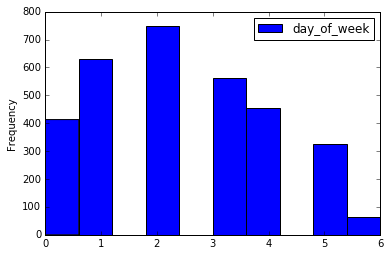

In [5]:
df.plot(x='created_at', y='day_of_week', kind='hist')
# fdf = df[["created_at","id","text","hashtags"]]
# str(fdf

Let's start getting some more detailed data from the trips as well

In [6]:
# df['favorite_count'] = df['favorite_count'].astype(np.int64)
# df['retweet_count'] = df['retweet_count'].astype(np.int64)
# df['text'] = df['text'].astype(str)
# df['id'] = df['id'].astype(np.int64)
# df['day_of_week'] = df['day_of_week'].astype(np.int64)
# df['day_of_month'] = df['day_of_month'].astype(np.int64)
# df['month'] = df['month'].astype(np.int64)
# df['time_of_day'] = df['time_of_day'].astype(np.int64)
df.loc[df["hashtags"]=='on',"hashtags"] = np.nan
df.convert_objects(convert_numeric=True)
df.dtypes
len(df)

/Users/albarron/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


3199

In [7]:
# Pull out potential trains from both hashtags and text
df["topic_train"] = df["text"].apply(lambda x: check_train_id(x))
df["topic_train"] = df["topic_train"].apply(lambda x: str(x)[1:-1])
df["topic_train"].fillna(np.nan)
df.head(5)

,created_at,favorite_count,hashtags,id,in_reply_to_screen_name,retweet_count,text,day_of_week,day_of_month,month,time_of_day,topic_train
0,2016-01-26 20:32:15,6,SanFrancisco,692082643022680064,NaN,7,NOTICE: Ped &amp; Bike detours in place for Ma...,1,26,1,error,
1,2016-01-26 19:41:32,NaN,,692069881559134208,therealwall,NaN,@therealwall After the end of the concert we w...,1,26,1,rush_evening,
2,2016-01-26 19:28:52,NaN,SB50,692066695838498816,AemalTheAFGHAN,NaN,@AemalTheAFGHAN @BKDenverSports We're glad to ...,1,26,1,rush_evening,'50'
3,2016-01-26 18:12:35,1,"Sorry, Headphones",692047497238175744,4c4d,NaN,"@4c4d Oh man. We love that, too. Our favorite ...",1,26,1,rush_evening,
4,2016-01-26 17:53:20,7,,692042650933862401,NaN,18,"Pssst, hey, regular Caltrain riders: expect a ...",1,26,1,rush_evening,


In [8]:
len(df)

3199

In [9]:
# pd.pivot_table(
#   df,values='values',
#   index=['month'],
#   columns=['day_of_week'])

First, a word about the below code.
In the accompanying `func.py` there is a function called parse_train that returns a `pandas.Series` object. For some reason, when it's returned from a map or apply, it seems to get cast as a string. When applied to a list or a dataframe, this string gets turned into a single field in the row, OR divided into several rows, throwing the count off.

To get around this, I return the results of the parse_train function and then CAST it back to a series. This adds a weird 0 index, which I delete. I then fill in the plethora of NaNs and recombine it with the primary dataframe.

For context, previous iterations included
`df['topic_train'].apply(lambda x:parse_train(x))`
which would return a pd.Series object with `str` versions of the returned pd.Series from `parse_train`

In [10]:
ret = []

def parse_train(t):
# x should be a list with train codes eg 123
# {"id": "123", "type:" "bullet", direction: "south"}

    try:
        s = t['topic_train'].split(',')
    except:
        return t['topic_train']
    if s[0] == '':
#         print ""
        return np.nan
    for x in s:
#         print "Iter",x[1:-1]
        q = {}
        # Check train id
#         x = parse_train_id(x)
        x = str(x)
        x = re.sub('[^0-9]','', x)
        if len(x)<3: continue

        # 1 = north, 0 = south
        q["t_northbound"] = 1 if int(x[2]) in [1,3,5,7,9] else 0
        q['t_limited'] = 0
        q['t_bullet'] = 0
        
        if x[0] == '1':
            q['t_limited'] = 0
        elif x[0] == '2':
            q["t_limited"] = 1 # limited
        elif x[0] == '3':
            q["t_bullet"] = 1 # bullet
        else:
            q['t_limited'] = 0

        ret.append({'tweet_id': t['id'],
                    'timestamp': t['created_at'], 
                    'train_id': int(x),
                    't_northbound':q["t_northbound"], 
                    't_limited': q["t_limited"],
                    't_bullet': q['t_bullet']})
    return s

In [11]:
# Let's then filter those train topics into details
# Btw this is jank as fuck.

# red = df[['id','created_at','topic_train']]
red = df.apply(lambda x:parse_train(x),axis=1)
print "red return:",len(red)
print "ret return,",len(ret)
#red
tf = pd.DataFrame(ret)
tf.head(5)

#events = pd.DataFrame([pd.Series(x) for x in red.apply(parse_train)])
#events
#del new.iloc[0]
#new.fillna('')
#df.combine_first(new)

red return: 3199
ret return, 528


,t_bullet,t_limited,t_northbound,timestamp,train_id,tweet_id
0,0,0,1,2016-01-25 23:42:14,155,691768068385718275
1,0,0,1,2016-01-22 22:48:57,151,690667494906814464
2,0,0,1,2016-01-20 22:22:55,151,689936168893329408
3,0,0,0,2016-01-19 18:08:25,138,689509733640732672
4,0,1,0,2016-01-19 16:32:04,216,689485484838416388


In [12]:
print df.loc[df['topic_train'] != '',['topic_train','text']]

              topic_train                                               text
2                    '50'  @AemalTheAFGHAN @BKDenverSports We're glad to ...
8                    '50'  @iamsridhar we are adding extra trains &amp; c...
16                  '155'                  #NB155 is 22 mins late. #Caltrain
21                   '50'  RT @smctd: #Caltrain Devs: NEW Super Bowl sche...
22               '50', ''  Headed to #SantaClara for #SB50? Visit our SB ...
29                   '50'  RT @Broncos: We #BeatThePatriots!\n\nSee you i...
30                   '50'  We look forward to getting #CAR @Panthers, #DE...
32                  '151'        #NB 151 is running 10 mins behind #Caltrain
33                     ''  Trains 236-254 will board on the NB platform t...
44                  '151'     #NB151 is 10 mins down at San Mateo. #Caltrain
51                  '138'  #SB138 will board on the northbound platform a...
55    '216', '225', '329'  #SB216 delayed 13 minutes at SAT\n#NB225 delay...

In [13]:
len(tf)

528

In [14]:
len(tf)

528

In [15]:
df = df.merge(tf, left_on='id',right_on='tweet_id',how='right')

In [16]:
df.groupby(['time_of_day','month']).mean()

favorite_count            id  retweet_count  day_of_week  \
time_of_day  month                                                             
error        1            1.722222  6.869895e+17       3.280000     2.480000   
             6            1.437500  6.126169e+17       2.000000     3.567568   
             7            2.470588  6.223543e+17       4.953488     2.558140   
             8            2.480000  6.328767e+17       4.076923     2.826923   
             9            2.777778  6.439176e+17       3.909091     2.314286   
             10           1.857143  6.527556e+17       4.622222     2.688889   
             11           2.700000  6.652811e+17       3.562500     1.515152   
             12           2.000000  6.747415e+17       2.476190     3.681818   
rush_evening 1            1.875000  6.881407e+17       3.750000     0.750000   
             6            4.666667  6.125047e+17       1.818182     1.090909   
             7            1.333333  6.225477e+17       2.100000     1.750000   
             8            1.400000  6.352651e+17       2.428571     2.285714   
             9            2.000000  6.447491e+17       1.640000     1.840000   
             10           1.250000  6.529508e+17       2.210526     2.210526   
             11           1.200000  6.663183e+17       4.100000     0.700000   
             12           1.800000  6.740357e+17       3.700000     1.700000   
rush_morning 10           1.000000  6.520161e+17       1.000000     3.000000   
workday      1            1.000000  6.872953e+17       6.000000     2.000000   
             6            1.000000  6.114410e+17       1.571429     1.714286   
             7            2.333333  6.223477e+17       5.800000     1.300000   
             8                 NaN  6.342669e+17       2.333333     2.666667   
             9            1.714286  6.434607e+17       5.933333     2.866667   
             10           2.000000  6.525711e+17       4.000000     3.000000   
             12                NaN  6.724328e+17       4.666667     3.000000   

                    day_of_month  t_bullet  t_limited  t_northbound  \
time_of_day  month                                                    
error        1         12.360000  0.320000   0.200000      0.480000   
             6         21.216216  0.324324   0.378378      0.297297   
             7         18.162791  0.348837   0.441860      0.511628   
             8         16.057692  0.269231   0.461538      0.346154   
             9         15.514286  0.128571   0.471429      0.671429   
             10         9.866667  0.166667   0.466667      0.455556   
             11        13.272727  0.060606   0.393939      0.484848   
             12         9.727273  0.272727   0.318182      0.454545   
rush_evening 1         15.250000  0.375000   0.250000      0.625000   
             6         20.545455  0.181818   0.454545      0.545455   
             7         18.250000  0.050000   0.550000      0.550000   
             8         22.285714  0.000000   0.071429      0.785714   
             9         17.520000  0.080000   0.240000      0.800000   
             10        10.157895  0.105263   0.315789      0.684211   
             11        16.000000  0.100000   0.200000      0.900000   
             12         7.300000  0.100000   0.300000      0.500000   
rush_morning 10         8.000000  0.000000   0.000000      1.000000   
workday      1         13.000000  0.500000   0.500000      1.000000   
             6         17.714286  0.285714   0.571429      0.714286   
             7         17.800000  0.300000   0.700000      0.500000   
             8         19.666667  0.333333   0.666667      0.333333   
             9         14.066667  0.266667   0.666667      0.866667   
             10         9.166667  0.500000   0.000000      0.666667   
             12         3.000000  0.000000   1.000000      1.000000   

                      train_id      tweet_id  
time_of_day  month                           

In [17]:
list(df.columns.values)

['created_at',
 'favorite_count',
 'hashtags',
 'id',
 'in_reply_to_screen_name',
 'retweet_count',
 'text',
 'day_of_week',
 'day_of_month',
 'month',
 'time_of_day',
 'topic_train',
 't_bullet',
 't_limited',
 't_northbound',
 'timestamp',
 'train_id',
 'tweet_id']

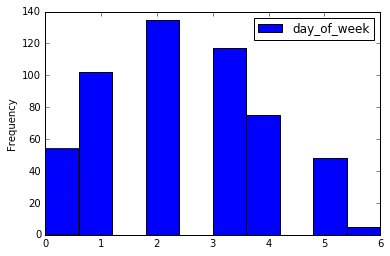

In [18]:
df.plot(x='time_of_day',y='day_of_week',kind='hist')

In [26]:
# pd.scatter_matrix(df,alpha=0.1,figsize=(15,15), diagonal='hist');

In [20]:
df.groupby('month').describe()

day_of_month  day_of_week  favorite_count            id  \
month                                                                  
1     count     35.000000    35.000000       28.000000  3.500000e+01   
      mean      13.057143     2.057143        1.714286  6.872701e+17   
      std        4.862479     1.493965        1.462042  1.777861e+15   
      min        4.000000     0.000000        1.000000  6.840946e+17   
      25%        9.500000     1.000000        1.000000  6.861119e+17   
      50%       12.000000     1.000000        1.000000  6.867537e+17   
      75%       15.000000     4.000000        2.000000  6.878042e+17   
      max       25.000000     4.000000        8.000000  6.917681e+17   
6     count     55.000000    55.000000       20.000000  5.500000e+01   
      mean      20.636364     2.836364        1.900000  6.124448e+17   
      std        5.873240     1.853562        1.586124  2.110101e+15   
      min        8.000000     0.000000        1.000000  6.079546e+17   
      25%       17.500000     1.000000        1.000000  6.113585e+17   
      50%       20.000000     3.000000        1.000000  6.120688e+17   
      75%       26.000000     4.500000        2.250000  6.144020e+17   
      max       30.000000     6.000000        6.000000  6.156911e+17   
7     count     73.000000    73.000000       26.000000  7.300000e+01   
      mean      18.136986     2.164384        2.192308  6.224064e+17   
      std        9.194375     1.280340        1.744001  3.334705e+15   
      min        1.000000     0.000000        1.000000  6.160466e+17   
      25%       14.000000     1.000000        1.000000  6.207510e+17   
      50%       20.000000     2.000000        2.000000  6.231497e+17   
      75%       25.000000     3.000000        2.750000  6.247474e+17   
      max       31.000000     5.000000        8.000000  6.272640e+17   
8     count     69.000000    69.000000       30.000000  6.900000e+01   
      mean      17.478261     2.710145        2.300000  6.334217e+17   
      std        9.827346     1.572759        1.263547  3.632823e+15   
      min        1.000000     0.000000        1.000000  6.272702e+17   
      25%       10.000000     1.000000        1.000000  6.308697e+17   
      50%       19.000000     3.000000        2.000000  6.341380e+17   
...                   ...          ...             ...           ...   
9     std        9.011368     1.341858        3.257780  3.245817e+15   
      min        1.000000     0.000000        1.000000  6.385084e+17   
      25%        9.000000     1.250000        1.000000  6.414256e+17   
      50%       14.000000     2.000000        1.000000  6.435046e+17   
      75%       23.000000     3.000000        3.000000  6.467907e+17   
      max       30.000000     5.000000       20.000000  6.493411e+17   
10    count    116.000000   116.000000       49.000000  1.160000e+02   
      mean       9.862069     2.629310        1.795918  6.527716e+17   
      std        7.033951     1.130834        1.731805  2.555516e+15   
      min        1.000000     0.000000        1.000000  6.496141e+17   
      25%        7.000000     2.000000        1.000000  6.515610e+17   
      50%        8.000000     3.000000        1.000000  6.520133e+17   
      75%       14.000000     3.000000        2.000000  6.541057e+17   
      max       30.000000     5.000000       11.000000  6.602246e+17   
11    count     43.000000    43.000000       25.000000  4.300000e+01   
      mean      13.906977     1.325581        2.400000  6.655223e+17   
      std        8.733662     1.209505        1.957890  3.138674e+15   
      min        2.000000     0.000000        1.000000  6.612370e+17   
      25%        7.500000     0.000000        1.000000  6.632601e+17   
      50%       12.000000     1.000000        2.000000  6.649104e+17   
      75%       20.000000     2.000000        3.000000  6.676899e+17   
      max       30.000000     4.000000        7.000000  6.713959e+17   
12    count     35.000000    35.000000       16.00000

In [21]:
train = df[df['train_id'] > 0]

In [22]:
train.groupby('day_of_week').count()

,created_at,favorite_count,hashtags,id,in_reply_to_screen_name,retweet_count,text,day_of_month,month,time_of_day,topic_train,t_bullet,t_limited,t_northbound,timestamp,train_id,tweet_id
day_of_week,,,,,,,,,,,,,,,,,
0,54,27,54,54,0,49,54,54,54,54,54,54,54,54,54,54,54
1,102,48,102,102,0,102,102,102,102,102,102,102,102,102,102,102,102
2,135,59,135,135,0,135,135,135,135,135,135,135,135,135,135,135,135
3,117,44,117,117,0,117,117,117,117,117,117,117,117,117,117,117,117
4,75,24,75,75,0,75,75,75,75,75,75,75,75,75,75,75,75
5,48,32,48,48,0,48,48,48,48,48,48,48,48,48,48,48,48
6,5,5,5,5,0,4,5,5,5,5,5,5,5,5,5,5,5


In [23]:
train.groupby('month').count()

,created_at,favorite_count,hashtags,id,in_reply_to_screen_name,retweet_count,text,day_of_week,day_of_month,time_of_day,topic_train,t_bullet,t_limited,t_northbound,timestamp,train_id,tweet_id
month,,,,,,,,,,,,,,,,,
1,35,28,35,35,0,35,35,35,35,35,35,35,35,35,35,35,35
6,55,20,55,55,0,55,55,55,55,55,55,55,55,55,55,55,55
7,73,26,73,73,0,73,73,73,73,73,73,73,73,73,73,73,73
8,69,30,69,69,0,69,69,69,69,69,69,69,69,69,69,69,69
9,110,45,110,110,0,106,110,110,110,110,110,110,110,110,110,110,110
10,116,49,116,116,0,116,116,116,116,116,116,116,116,116,116,116,116
11,43,25,43,43,0,42,43,43,43,43,43,43,43,43,43,43,43
12,35,16,35,35,0,34,35,35,35,35,35,35,35,35,35,35,35


In [24]:
train.groupby('time_of_day').count()

,created_at,favorite_count,hashtags,id,in_reply_to_screen_name,retweet_count,text,day_of_week,day_of_month,month,topic_train,t_bullet,t_limited,t_northbound,timestamp,train_id,tweet_id
time_of_day,,,,,,,,,,,,,,,,,
error,372,185,372,372,0,366,372,372,372,372,372,372,372,372,372,372,372
rush_evening,117,38,117,117,0,117,117,117,117,117,117,117,117,117,117,117,117
rush_morning,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1
workday,46,15,46,46,0,46,46,46,46,46,46,46,46,46,46,46,46


In [25]:
df.corr()

,favorite_count,id,retweet_count,day_of_week,day_of_month,month,t_bullet,t_limited,t_northbound,train_id,tweet_id
favorite_count,1.000000,-0.056542,0.551203,0.100412,-0.013727,0.057577,0.184392,0.019418,0.071410,0.182412,-0.056542
id,-0.056542,1.000000,0.024774,-0.083374,-0.201225,0.119187,-0.048254,-0.091769,0.070766,-0.083925,1.000000
retweet_count,0.551203,0.024774,1.000000,0.019303,-0.058542,0.030757,0.096546,0.100636,-0.041501,0.148645,0.024774
day_of_week,0.100412,-0.083374,0.019303,1.000000,-0.063651,0.022254,0.047302,-0.022492,-0.061165,0.132644,-0.083374
day_of_month,-0.013727,-0.201225,-0.058542,-0.063651,1.000000,-0.204438,0.014090,0.057579,0.053588,-0.007253,-0.201225
month,0.057577,0.119187,0.030757,0.022254,-0.204438,1.000000,-0.145967,0.041591,0.045134,-0.039853,0.119187
t_bullet,0.184392,-0.048254,0.096546,0.047302,0.014090,-0.145967,1.000000,-0.416707,-0.010226,0.651110,-0.048254
t_limited,0.019418,-0.091769,0.100636,-0.022492,0.057579,0.041591,-0.416707,1.000000,-0.041419,0.110541,-0.091769
t_northbound,0.071410,0.070766,-0.041501,-0.061165,0.053588,0.045134,-0.010226,-0.041419,1.000000,0.008933,0.070766
train_id,0.182412,-0.083925,0.148645,0.132644,-0.007253,-0.039853,0.651110,0.110541,0.008933,1.000000,-0.083925
